# Lab One : Visualization and Data Pre-processing

### Group 3 - Members:

_Apurv Mittal_<br>
_Seemant Srivastava_<br>
_Ravi Sivaraman_<br>
_Tai Chowdhury_<br>


In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from scipy import stats
import warnings
from shapely.geometry import Point
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import resample



In [ ]:
#Ignore Warnings on final

warnings.filterwarnings('ignore')

In [ ]:
# Read the Australia weather data
df = pd.read_csv("weatherAUS.csv")

In [ ]:
#  View the top rows of the data imported
df.head()

In [ ]:
#Drop Date and Location

df = df.drop(['Date', 'Location'], axis = 1)

In [ ]:
# Removing records which are blank for Rain today and Rain tomorrow

df.dropna(subset = ["RainToday"], inplace=True)
df.dropna(subset = ["RainTomorrow"], inplace=True)


# Seperate the data into categorical and numeric

df_num = df.columns[df.dtypes == 'float64']
df_cat=df.columns[df.dtypes == 'object']
print("Numeric Variables:", df_num)
print("Categorical Variables:", df_cat)

# REFERENCE: https://www.kite.com/python/answers/how-to-drop-empty-rows-from-a-pandas-dataframe-in-python

#### Data Imputation

In [ ]:
# Impute data (numeric) based on the mean for RainToday and RainTomorrow

df_impute = df
mat_yesno = df[df_num].groupby([df['RainToday'],df['RainTomorrow']]).mean()
RAINTODAY=0
RAINTOMORROW=1
COUNTER = 0
for i in range(2):
    for j in range(2):
        for indexattr in mat_yesno.iloc[COUNTER].index:
            df_impute.loc[(df_impute["RainToday"] == mat_yesno.iloc[COUNTER].name[RAINTODAY] ) 
                          & (df_impute["RainTomorrow"] == mat_yesno.iloc[COUNTER].name[RAINTOMORROW]) 
                          & (df_impute[indexattr].isnull()), indexattr] = mat_yesno.iloc[COUNTER][indexattr]
        COUNTER = COUNTER + 1

        
        
# Impute data (categorical) with mode of each variable

df_impute['WindDir9am'] = df_impute['WindDir9am'].fillna(df_impute['WindDir9am'].mode()[0])
df_impute['WindGustDir'] = df_impute['WindGustDir'].fillna(df_impute['WindGustDir'].mode()[0])
df_impute['WindDir3pm'] = df_impute['WindDir3pm'].fillna(df_impute['WindDir3pm'].mode()[0])

As mentioned above, we imputed data for all numeric variables with the means for the combination of `RainToday` and `RainTomorrow`. We calcualted the value for `RainToday` and `RainTomorrow` both as "No" and imputed the data for the missing variables for such combination, similary calculated `RainToday` as "Yes" and `RainTomorrow` as "No" and imputed the mean value for the variable so and so forth.

For categorical variables `WindDir9am`, `WindDir3pm` are covering the direction of the wind at different 9 am and 3 pm respectively, while `WindGustDir`is the direction of the wind gust. All these variables are about the direction and and the largest missing variable is `6.8%` for Wind Direction at 9 am. We decided to impute this data with the Mode for each of the categorical variable.


In [ ]:
df_impute_num = df.columns[df.dtypes == 'float64']
df_impute_cat=df.columns[df.dtypes == 'object']
print("Numeric Variables:", df_num)
print("Categorical Variables:", df_cat)

## Creating different dataframes for continous and categorical variables.
Assigning the `RainTomorrow` as our response variable (y) and all other continous variable as X

### Handling Class Imbalance For Rainfall Prediction

In [ ]:
#Keep the original data
df_model = df_impute.copy()

In [ ]:
#Change RainToday from categorical to continuous

df_model["IsRainToday"] = df_impute['RainToday']
#df_model['IsRainTomorrow'] = df_impute['RainTomorrow']

df_model['IsRainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
#df_model['IsRainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

In [ ]:
print("df_impute", df_impute.shape)
print("df_model", df_model.shape)


In [ ]:
df_model

In [ ]:
fig = plt.figure(figsize = (8,5))
df_model['RainTomorrow'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

In [ ]:
fig = plt.figure(figsize = (8,5))
df_model['RainToday'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainToday Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

We can observe that the presence of “0” and “1” is almost in the 78:22 ratio. So there is a class imbalance and we have to deal with it. To fight against the class imbalance, we will use here the oversampling of the minority class. Since the size of the dataset is quite small, majority class subsampling wouldn’t make much sense here.

## One hot encoding

In [ ]:
# perform one-hot encoding of the categorical data

gust_df = pd.get_dummies(df_model.WindGustDir,prefix='GustDir')
wind3pm_df = pd.get_dummies(df_model.WindDir3pm,prefix='Wind3pm')
wind9am_df = pd.get_dummies(df_model.WindDir9am,prefix='Wind9am')
df_model = pd.concat((df_model,gust_df, wind3pm_df, wind9am_df),axis=1) # add back into the dataframe


In [ ]:
# Drop categorical columns

df_model = df_model.drop(['WindDir3pm', 'WindDir9am', 'WindGustDir', 'RainToday'], axis = 1)

In [ ]:
#Check if Yes is replaced as 1

print("Are there 1's and 0's in the RainToday column?", 
      (df_model['IsRainToday'].sum() > 0) and (df_model['IsRainToday'].sum() < len(df_model['IsRainToday'])))

#Non zero output means there is a mixture of 1's and 0's
#if sum is less

In [ ]:
X=df_model[df_num]
y = df_model.RainTomorrow
print('features shape:', X.shape) 
print('target shape:', y.shape )

### Models

In [19]:
#Logistic Regression Function
#Run with various parameters
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

def create_models(model_type,df, iterations,class_weight, penalty, solver, C, l1_ratio):
    lr_clf = LogisticRegression(penalty=penalty, C=C, class_weight=class_weight, solver=solver) 

    num_cv_iterations = iterations
    rain_tom_df = None
    cv_dat = None
   
    if "RainTomorrow" in df:
        y = df["RainTomorrow"].values # get the labels we want
        del df["RainTomorrow"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    num_instances = len(y)
    if model_type == "shuffle" or model_type == "svm":
        cv_data = ShuffleSplit(n_splits=num_cv_iterations,
                             test_size  = 0.2, random_state = 123)

    elif model_type == "stratified":
        cv_data = StratifiedKFold(n_splits=iterations, random_state=123, shuffle=True)
        cv_data.get_n_splits(X, y)

       
    iter_num=0
    rows = []
    scl_obj = StandardScaler()
    for train_indices, test_indices in cv_data.split(X,y): 
        X_train = X[train_indices]
        y_train = y[train_indices]
        
        scl_obj.fit(X_train)

        X_test = X[test_indices]
        y_test = y[test_indices]
        try:
            X_train_scaled = scl_obj.transform(X_train) 
            X_test_scaled = scl_obj.transform(X_test)
            y_hat = None
            classes = None
            if model_type == "svm":
                svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
                svm_clf.fit(X_train_scaled, y_train)  # train object
                y_hat = svm_clf.predict(X_test_scaled) # get test set precitions
                classes = svm_clf.classes_

            else:
                # shuffle and stratifed models using logistic reg
                lr_clf.fit(X_train_scaled,y_train)  # train object
                y_hat = lr_clf.predict(X_test_scaled) # get test set precitions
                classes = lr_clf.classes_

            acc = mt.accuracy_score(y_test,y_hat)
            conf = mt.confusion_matrix(y_test,y_hat)
            target_names = ['No', 'Yes']
            class_report = classification_report(y_test, y_hat, target_names)
            
            # Create ROC Curve
            y_test_01 = np.where(y_test =="Yes", 1, [0])
            print("y_test", y_test)
            print("y_test_01", y_test_01)
            print("y_hat", y_hat)
            y_hat_01 = np.where(y_hat =="Yes", 1, [0])

            fpr, tpr, threshold = metrics.roc_curve(y_test_01, y_hat_01)
            print("fpr", fpr)
            print("tr", tpr)
            rows.append([model_type,solver,class_weight,C,penalty,iter_num, acc, conf, class_report, fpr,tpr])

            print("Iteration",solver,class_weight,C,penalty,iter_num,"-----> Done")
            disp = mt.ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=classes)
            disp.plot()
        except Exception as e:
            print('Error:', str(e))
            raise
        iter_num+=1   
   
    df_ret = pd.DataFrame(rows, columns=["ModelType","Solver", "ClassWeight", "C", "Penalty","Iteration","Accuracy","ConfusionMatrix", 
                                         "ClassificationReport","fpr", "tpr"])
    return df_ret


Error: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running 'NoneType' object has no attribute 'iterrows'
Error: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running 'NoneType' object has no attribute 'iterrows'
y_test ['No' 'No' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 0 1 ... 0 0 0]
y_hat ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.14802841 1.        ]
tr [0.         0.85313105 1.        ]
Iteration liblinear balanced 1.0 l1 0 -----> Done
y_test ['Yes' 'No' 'No' ... 'No' 'No' 'Yes']
y_test_01 [1 0 0 ... 0 0 1]
y_hat ['Yes' 'No' 'Yes' ... 'No' 'No' 'Yes']
fpr [0.         0.14806877 1.        ]
tr [0.         0.85631723 1.        ]
Iteration liblinear balanced 1.0 l1 1 -----> Done
y_test ['No' 'Yes' 'No' ... 'No' 'No' 'No']
y_test_01 

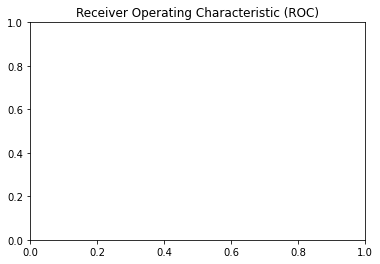

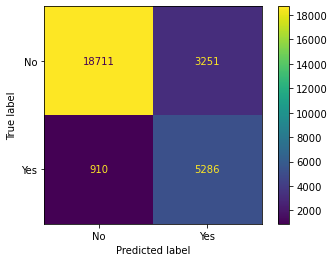

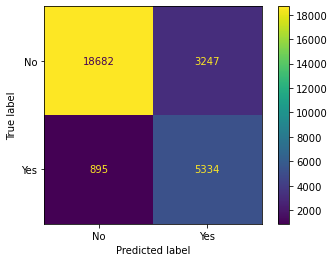

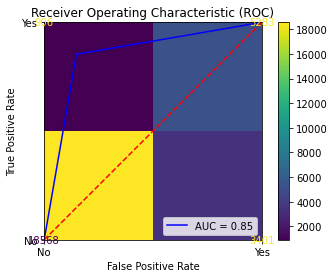

fpr [0.         0.14806877 1.        ]
tpr [0.         0.85631723 1.        ]


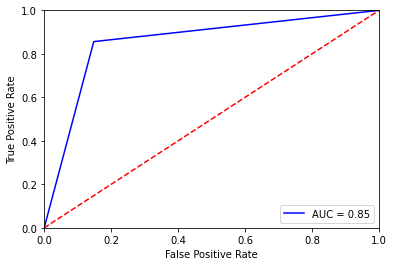

fpr [0.         0.15480905 1.        ]
tpr [0.         0.85361125 1.        ]


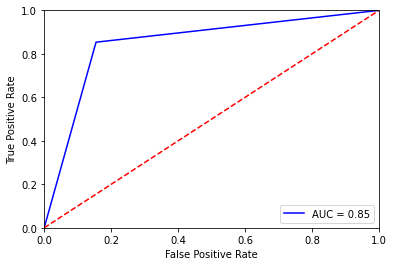

y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.        0.1532481 1.       ]
tr [0.   0.86 1.  ]
Iteration liblinear balanced 1.0 l1 0 -----> Done
y_test ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 1 1 ... 0 0 0]
y_hat ['No' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.14925128 1.        ]
tr [0.         0.85038462 1.        ]
Iteration liblinear balanced 1.0 l1 1 -----> Done
y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15150022 1.        ]
tr [0.        0.8529949 1.       ]
Iteration liblinear balanced 1.0 l1 2 -----> Done
fpr [0.        0.1532481 1.       ]
tpr [0.   0.86 1.  ]


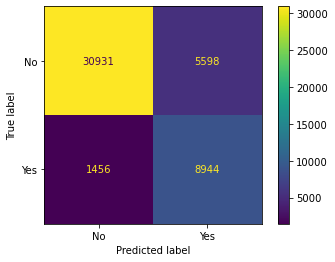

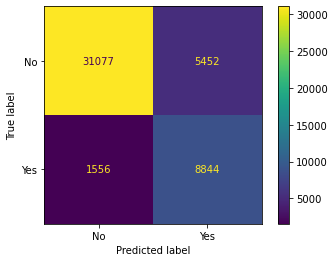

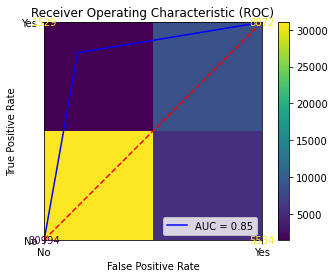

fpr [0.         0.14925128 1.        ]
tpr [0.         0.85038462 1.        ]


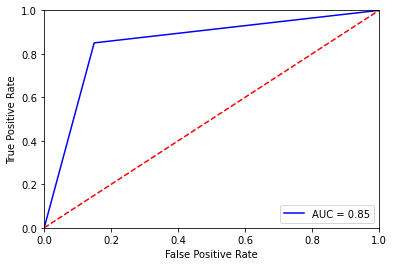

fpr [0.         0.15150022 1.        ]
tpr [0.        0.8529949 1.       ]


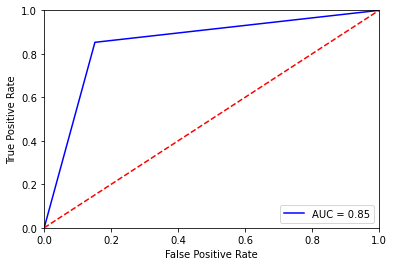

Error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running 'NoneType' object has no attribute 'iterrows'
y_test ['No' 'No' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 0 1 ... 0 0 0]
y_hat ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.14802841 1.        ]
tr [0.         0.85313105 1.        ]
Iteration saga balanced 1.0 l1 0 -----> Done
y_test ['Yes' 'No' 'No' ... 'No' 'No' 'Yes']
y_test_01 [1 0 0 ... 0 0 1]
y_hat ['Yes' 'No' 'Yes' ... 'No' 'No' 'Yes']
fpr [0.         0.14806877 1.        ]
tr [0.         0.85631723 1.        ]
Iteration saga balanced 1.0 l1 1 -----> Done
y_test ['No' 'Yes' 'No' ... 'No' 'No' 'No']
y_test_01 [0 1 0 ... 0 0 0]
y_hat ['No' 'Yes' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15480905 1.        ]
tr [0.         0.85361125 1.        ]
Iteration saga balanced 1.0 l1 2 -----> Done
fpr [0.         0.14802841 1.        ]
tpr [0.         0.8531310

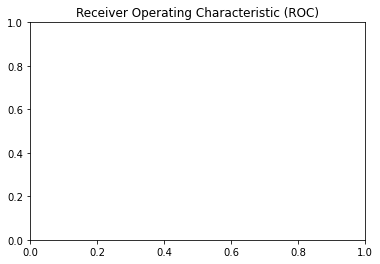

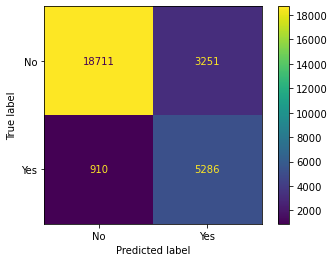

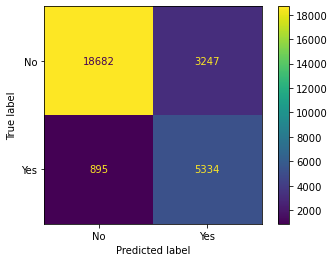

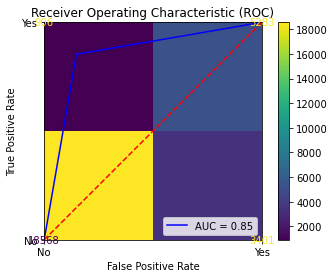

fpr [0.         0.14806877 1.        ]
tpr [0.         0.85631723 1.        ]


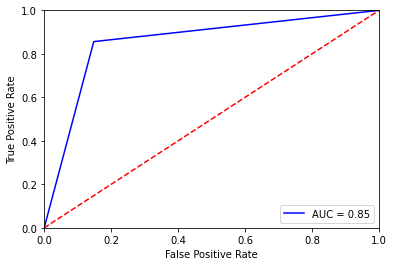

fpr [0.         0.15480905 1.        ]
tpr [0.         0.85361125 1.        ]


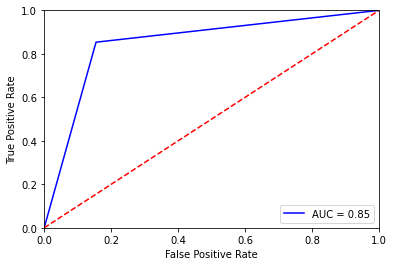

y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.        0.1532481 1.       ]
tr [0.   0.86 1.  ]
Iteration saga balanced 1.0 l1 0 -----> Done
y_test ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 1 1 ... 0 0 0]
y_hat ['No' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.14919653 1.        ]
tr [0.         0.85038462 1.        ]
Iteration saga balanced 1.0 l1 1 -----> Done
y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15144547 1.        ]
tr [0.        0.8529949 1.       ]
Iteration saga balanced 1.0 l1 2 -----> Done
fpr [0.        0.1532481 1.       ]
tpr [0.   0.86 1.  ]


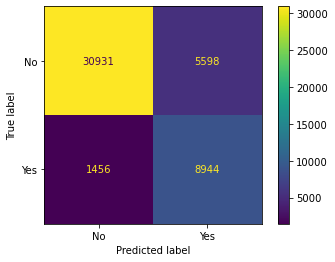

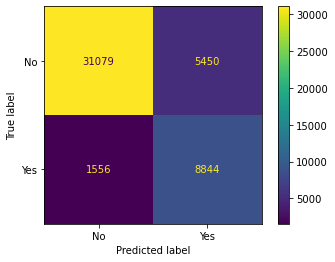

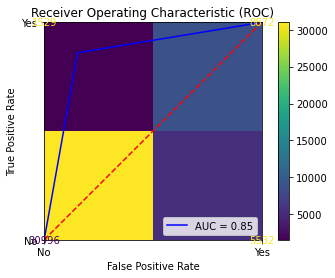

fpr [0.         0.14919653 1.        ]
tpr [0.         0.85038462 1.        ]


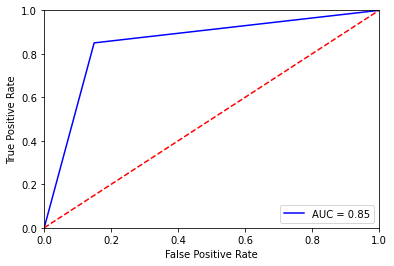

fpr [0.         0.15144547 1.        ]
tpr [0.        0.8529949 1.       ]


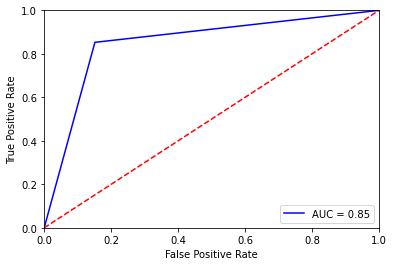

Error: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running 'NoneType' object has no attribute 'iterrows'
Error: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running 'NoneType' object has no attribute 'iterrows'
y_test ['No' 'No' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 0 1 ... 0 0 0]
y_hat ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.05637009 1.        ]
tr [0.        0.6396062 1.       ]
Iteration liblinear None 1.0 l1 0 -----> Done
y_test ['Yes' 'No' 'No' ... 'No' 'No' 'Yes']
y_test_01 [1 0 0 ... 0 0 1]
y_hat ['Yes' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.05700214 1.        ]
tr [0.         0.64488682 1.        ]
Iteration liblinear None 1.0 l1 1 -----> Done
y_test ['No' 'Yes' 'No' ... 'No' 'No' 'No']
y_test_01 [0 1 0 ... 0

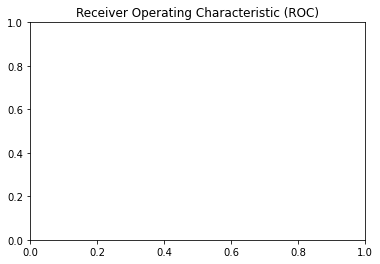

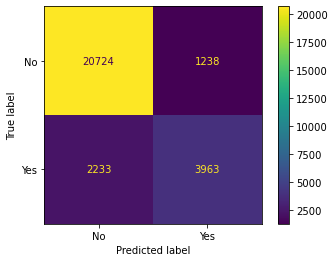

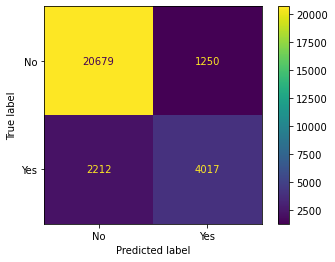

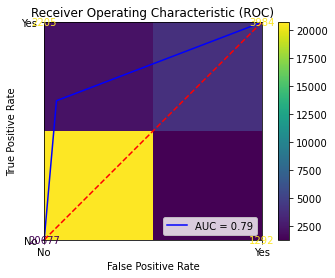

fpr [0.         0.05700214 1.        ]
tpr [0.         0.64488682 1.        ]


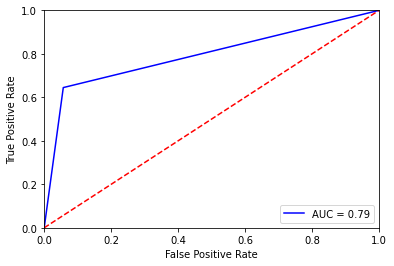

fpr [0.         0.05881014 1.        ]
tpr [0.         0.64372273 1.        ]


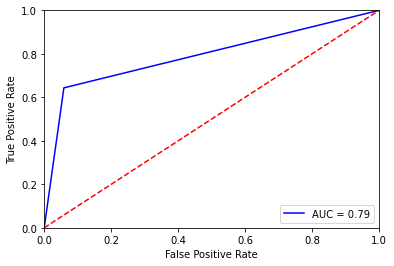

y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.05907635 1.        ]
tr [0.         0.64298077 1.        ]
Iteration liblinear None 1.0 l1 0 -----> Done
y_test ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 1 1 ... 0 0 0]
y_hat ['No' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.05762545 1.        ]
tr [0.         0.63730769 1.        ]
Iteration liblinear None 1.0 l1 1 -----> Done
y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.05896846 1.        ]
tr [0.         0.64253437 1.        ]
Iteration liblinear None 1.0 l1 2 -----> Done
fpr [0.         0.05907635 1.        ]
tpr [0.         0.64298077 1.        ]


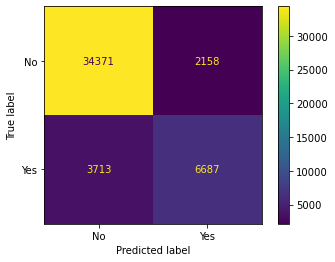

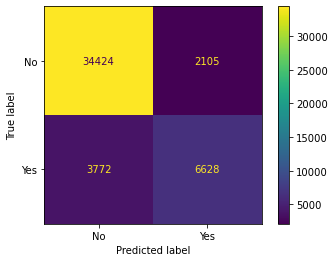

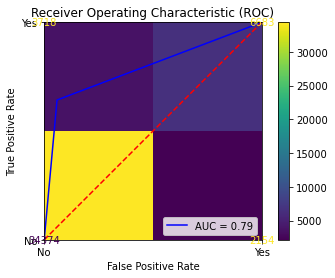

fpr [0.         0.05762545 1.        ]
tpr [0.         0.63730769 1.        ]


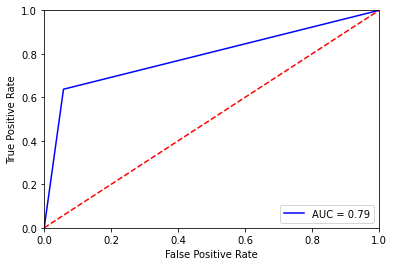

fpr [0.         0.05896846 1.        ]
tpr [0.         0.64253437 1.        ]


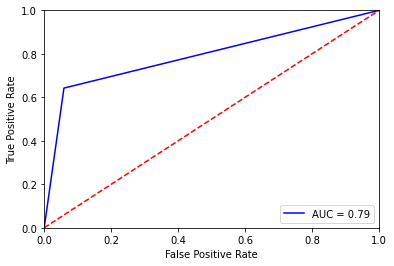

Error: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running 'NoneType' object has no attribute 'iterrows'
y_test ['No' 'No' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 0 1 ... 0 0 0]
y_hat ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.05637009 1.        ]
tr [0.        0.6396062 1.       ]
Iteration saga None 1.0 l1 0 -----> Done
y_test ['Yes' 'No' 'No' ... 'No' 'No' 'Yes']
y_test_01 [1 0 0 ... 0 0 1]
y_hat ['Yes' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.05700214 1.        ]
tr [0.         0.64488682 1.        ]
Iteration saga None 1.0 l1 1 -----> Done
y_test ['No' 'Yes' 'No' ... 'No' 'No' 'No']
y_test_01 [0 1 0 ... 0 0 0]
y_hat ['No' 'Yes' 'No' ... 'No' 'No' 'No']
fpr [0.         0.05881014 1.        ]
tr [0.         0.64372273 1.        ]
Iteration saga None 1.0 l1 2 -----> Done
fpr [0.         0.05637009 1.        ]
tpr [0.        0.6396062 1.       ]


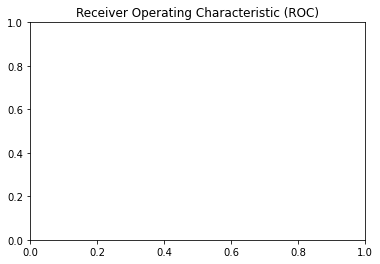

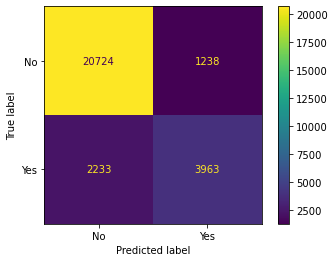

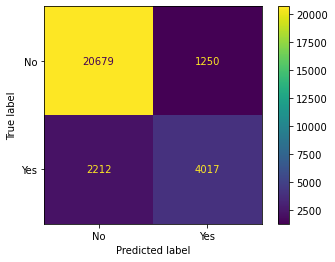

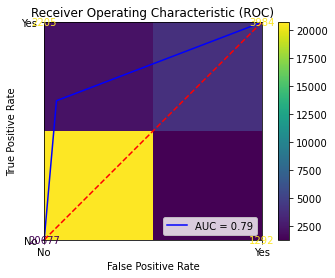

fpr [0.         0.05700214 1.        ]
tpr [0.         0.64488682 1.        ]


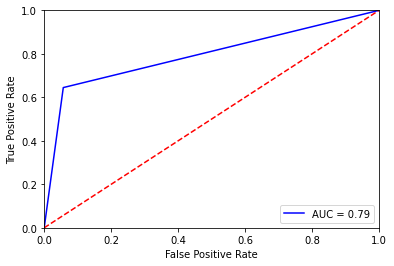

fpr [0.         0.05881014 1.        ]
tpr [0.         0.64372273 1.        ]


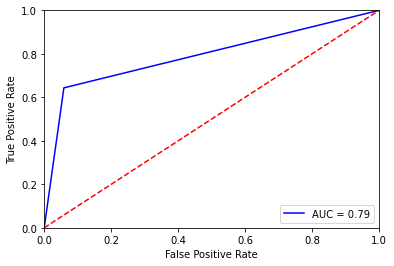

y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.05907635 1.        ]
tr [0.         0.64298077 1.        ]
Iteration saga None 1.0 l1 0 -----> Done
y_test ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 1 1 ... 0 0 0]
y_hat ['No' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.05762545 1.        ]
tr [0.     0.6375 1.    ]
Iteration saga None 1.0 l1 1 -----> Done
y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.05896846 1.        ]
tr [0.         0.64253437 1.        ]
Iteration saga None 1.0 l1 2 -----> Done
fpr [0.         0.05907635 1.        ]
tpr [0.         0.64298077 1.        ]


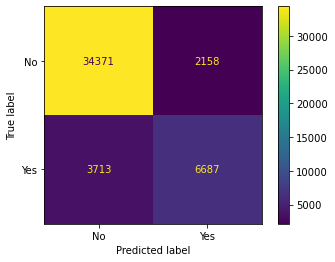

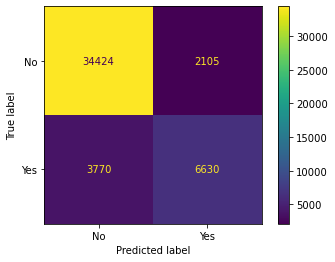

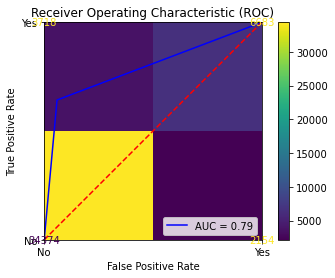

fpr [0.         0.05762545 1.        ]
tpr [0.     0.6375 1.    ]


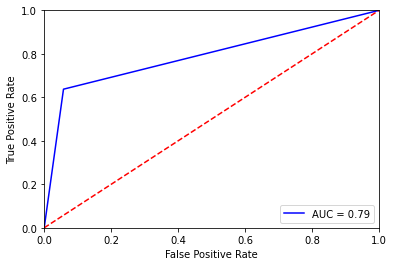

fpr [0.         0.05896846 1.        ]
tpr [0.         0.64253437 1.        ]


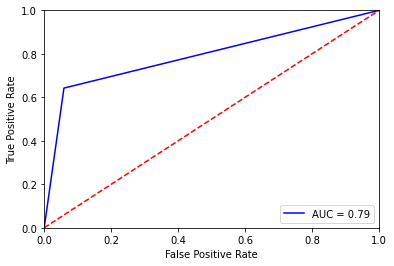

y_test ['No' 'No' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 0 1 ... 0 0 0]
y_hat ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.14807395 1.        ]
tr [0.         0.85296966 1.        ]
Iteration newton-cg balanced 1.0 l2 0 -----> Done
y_test ['Yes' 'No' 'No' ... 'No' 'No' 'Yes']
y_test_01 [1 0 0 ... 0 0 1]
y_hat ['Yes' 'No' 'Yes' ... 'No' 'No' 'Yes']
fpr [0.         0.14806877 1.        ]
tr [0.        0.8566383 1.       ]
Iteration newton-cg balanced 1.0 l2 1 -----> Done
y_test ['No' 'Yes' 'No' ... 'No' 'No' 'No']
y_test_01 [0 1 0 ... 0 0 0]
y_hat ['No' 'Yes' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15490009 1.        ]
tr [0.         0.85361125 1.        ]
Iteration newton-cg balanced 1.0 l2 2 -----> Done
fpr [0.         0.14807395 1.        ]
tpr [0.         0.85296966 1.        ]


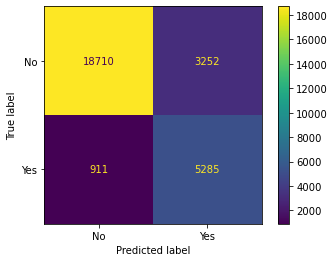

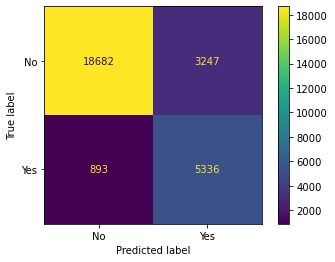

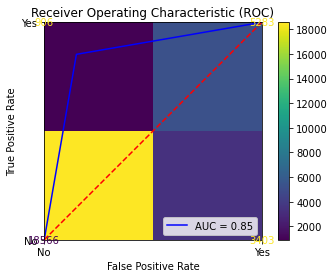

fpr [0.         0.14806877 1.        ]
tpr [0.        0.8566383 1.       ]


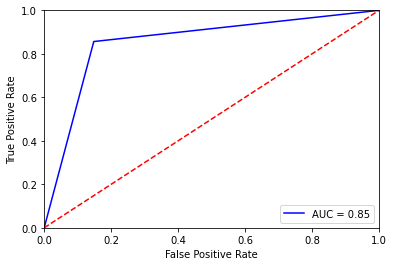

fpr [0.         0.15490009 1.        ]
tpr [0.         0.85361125 1.        ]


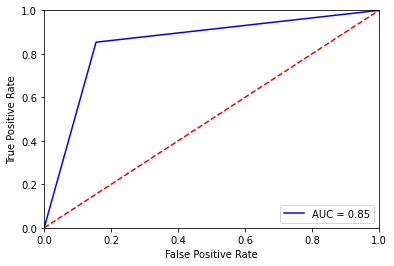

y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15327548 1.        ]
tr [0.         0.85990385 1.        ]
Iteration newton-cg balanced 1.0 l2 0 -----> Done
y_test ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 1 1 ... 0 0 0]
y_hat ['No' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.14927866 1.        ]
tr [0.         0.85038462 1.        ]
Iteration newton-cg balanced 1.0 l2 1 -----> Done
y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15150022 1.        ]
tr [0.        0.8529949 1.       ]
Iteration newton-cg balanced 1.0 l2 2 -----> Done
fpr [0.         0.15327548 1.        ]
tpr [0.         0.85990385 1.        ]


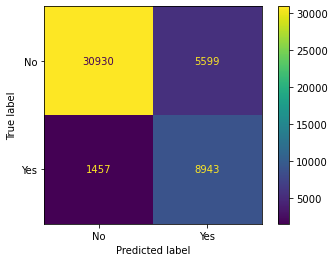

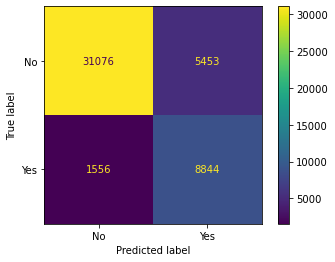

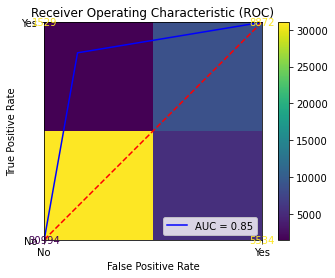

fpr [0.         0.14927866 1.        ]
tpr [0.         0.85038462 1.        ]


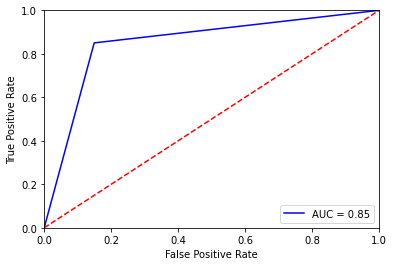

fpr [0.         0.15150022 1.        ]
tpr [0.        0.8529949 1.       ]


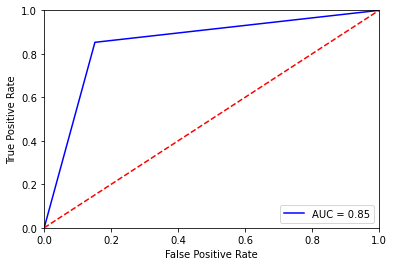

y_test ['No' 'No' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 0 1 ... 0 0 0]
y_hat ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.14807395 1.        ]
tr [0.         0.85296966 1.        ]
Iteration lbfgs balanced 1.0 l2 0 -----> Done
y_test ['Yes' 'No' 'No' ... 'No' 'No' 'Yes']
y_test_01 [1 0 0 ... 0 0 1]
y_hat ['Yes' 'No' 'Yes' ... 'No' 'No' 'Yes']
fpr [0.         0.14802317 1.        ]
tr [0.        0.8566383 1.       ]
Iteration lbfgs balanced 1.0 l2 1 -----> Done
y_test ['No' 'Yes' 'No' ... 'No' 'No' 'No']
y_test_01 [0 1 0 ... 0 0 0]
y_hat ['No' 'Yes' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15490009 1.        ]
tr [0.         0.85361125 1.        ]
Iteration lbfgs balanced 1.0 l2 2 -----> Done
fpr [0.         0.14807395 1.        ]
tpr [0.         0.85296966 1.        ]


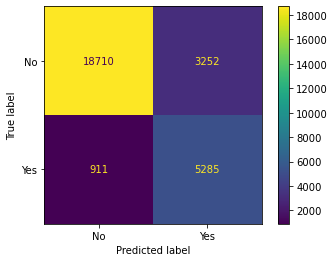

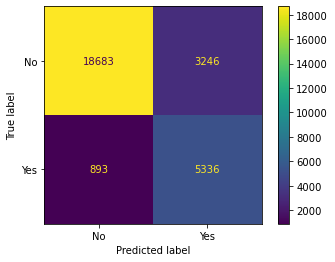

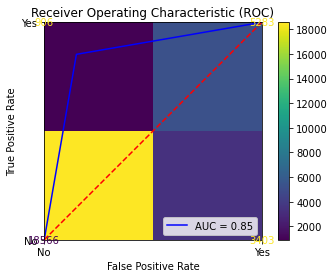

fpr [0.         0.14802317 1.        ]
tpr [0.        0.8566383 1.       ]


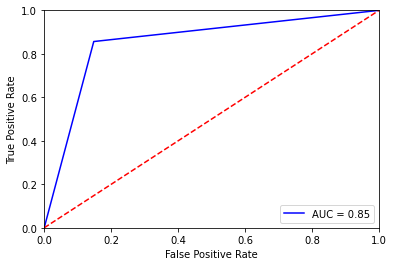

fpr [0.         0.15490009 1.        ]
tpr [0.         0.85361125 1.        ]


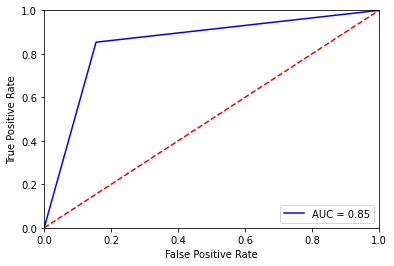

y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.        0.1532481 1.       ]
tr [0.         0.85990385 1.        ]
Iteration lbfgs balanced 1.0 l2 0 -----> Done
y_test ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 1 1 ... 0 0 0]
y_hat ['No' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.14927866 1.        ]
tr [0.         0.85038462 1.        ]
Iteration lbfgs balanced 1.0 l2 1 -----> Done
y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15150022 1.        ]
tr [0.         0.85309105 1.        ]
Iteration lbfgs balanced 1.0 l2 2 -----> Done
fpr [0.        0.1532481 1.       ]
tpr [0.         0.85990385 1.        ]


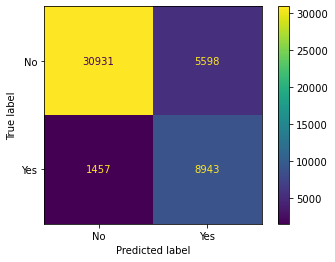

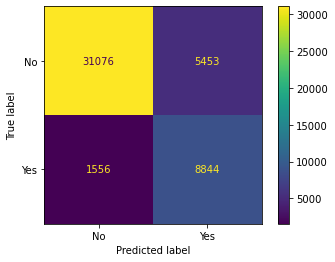

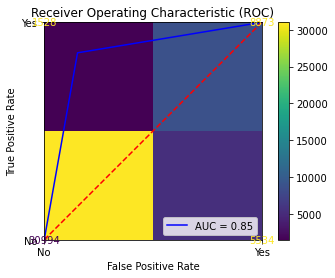

fpr [0.         0.14927866 1.        ]
tpr [0.         0.85038462 1.        ]


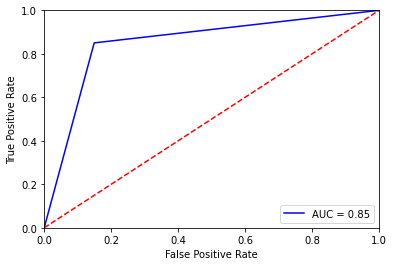

fpr [0.         0.15150022 1.        ]
tpr [0.         0.85309105 1.        ]


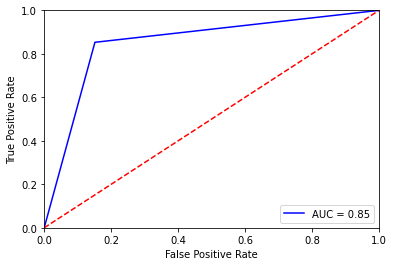

y_test ['No' 'No' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 0 1 ... 0 0 0]
y_hat ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.14807395 1.        ]
tr [0.         0.85296966 1.        ]
Iteration liblinear balanced 1.0 l2 0 -----> Done
y_test ['Yes' 'No' 'No' ... 'No' 'No' 'Yes']
y_test_01 [1 0 0 ... 0 0 1]
y_hat ['Yes' 'No' 'Yes' ... 'No' 'No' 'Yes']
fpr [0.         0.14806877 1.        ]
tr [0.        0.8566383 1.       ]
Iteration liblinear balanced 1.0 l2 1 -----> Done
y_test ['No' 'Yes' 'No' ... 'No' 'No' 'No']
y_test_01 [0 1 0 ... 0 0 0]
y_hat ['No' 'Yes' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15490009 1.        ]
tr [0.         0.85361125 1.        ]
Iteration liblinear balanced 1.0 l2 2 -----> Done
fpr [0.         0.14807395 1.        ]
tpr [0.         0.85296966 1.        ]


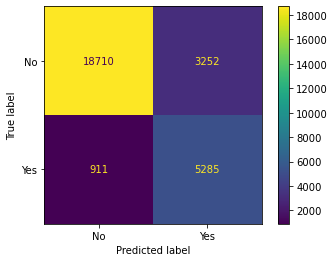

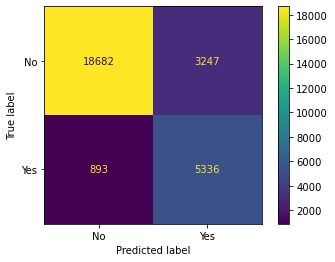

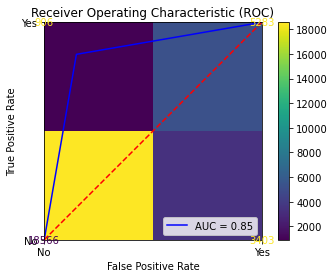

fpr [0.         0.14806877 1.        ]
tpr [0.        0.8566383 1.       ]


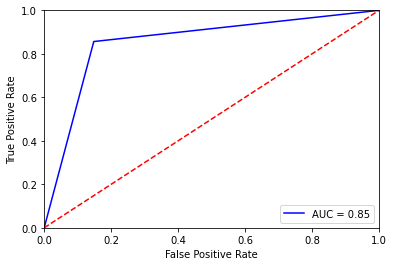

fpr [0.         0.15490009 1.        ]
tpr [0.         0.85361125 1.        ]


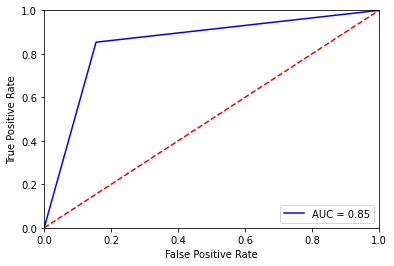

y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15327548 1.        ]
tr [0.   0.86 1.  ]
Iteration liblinear balanced 1.0 l2 0 -----> Done
y_test ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 1 1 ... 0 0 0]
y_hat ['No' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.14927866 1.        ]
tr [0.         0.85038462 1.        ]
Iteration liblinear balanced 1.0 l2 1 -----> Done
y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15150022 1.        ]
tr [0.         0.85309105 1.        ]
Iteration liblinear balanced 1.0 l2 2 -----> Done
fpr [0.         0.15327548 1.        ]
tpr [0.   0.86 1.  ]


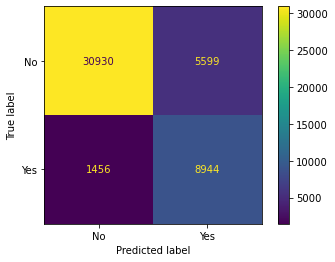

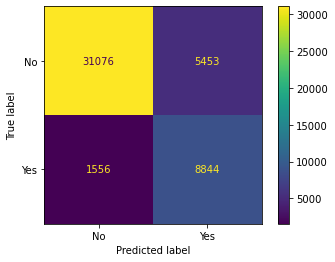

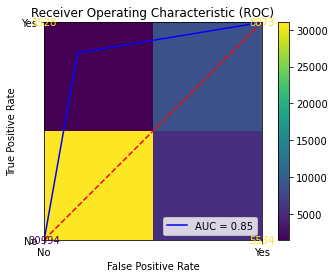

fpr [0.         0.14927866 1.        ]
tpr [0.         0.85038462 1.        ]


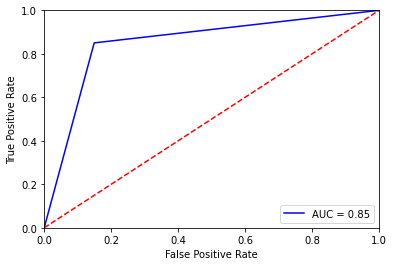

fpr [0.         0.15150022 1.        ]
tpr [0.         0.85309105 1.        ]


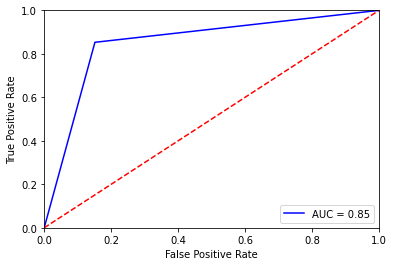

y_test ['No' 'No' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 0 1 ... 0 0 0]
y_hat ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.14807395 1.        ]
tr [0.         0.85296966 1.        ]
Iteration sag balanced 1.0 l2 0 -----> Done
y_test ['Yes' 'No' 'No' ... 'No' 'No' 'Yes']
y_test_01 [1 0 0 ... 0 0 1]
y_hat ['Yes' 'No' 'Yes' ... 'No' 'No' 'Yes']
fpr [0.         0.14802317 1.        ]
tr [0.        0.8566383 1.       ]
Iteration sag balanced 1.0 l2 1 -----> Done
y_test ['No' 'Yes' 'No' ... 'No' 'No' 'No']
y_test_01 [0 1 0 ... 0 0 0]
y_hat ['No' 'Yes' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15490009 1.        ]
tr [0.         0.85361125 1.        ]
Iteration sag balanced 1.0 l2 2 -----> Done
fpr [0.         0.14807395 1.        ]
tpr [0.         0.85296966 1.        ]


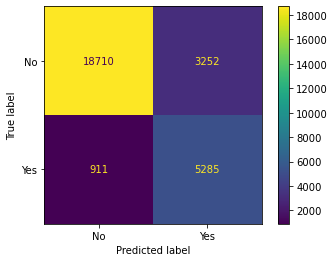

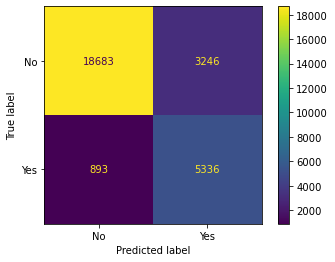

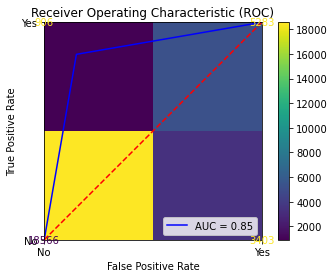

fpr [0.         0.14802317 1.        ]
tpr [0.        0.8566383 1.       ]


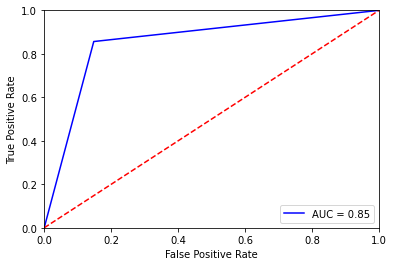

fpr [0.         0.15490009 1.        ]
tpr [0.         0.85361125 1.        ]


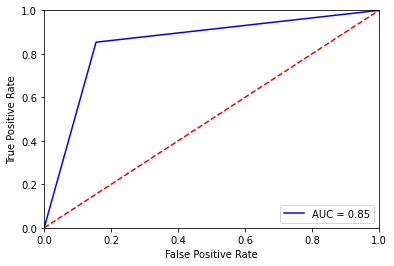

y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.        0.1532481 1.       ]
tr [0.         0.85990385 1.        ]
Iteration sag balanced 1.0 l2 0 -----> Done
y_test ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 1 1 ... 0 0 0]
y_hat ['No' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.14925128 1.        ]
tr [0.         0.85038462 1.        ]
Iteration sag balanced 1.0 l2 1 -----> Done
y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15150022 1.        ]
tr [0.         0.85309105 1.        ]
Iteration sag balanced 1.0 l2 2 -----> Done
fpr [0.        0.1532481 1.       ]
tpr [0.         0.85990385 1.        ]


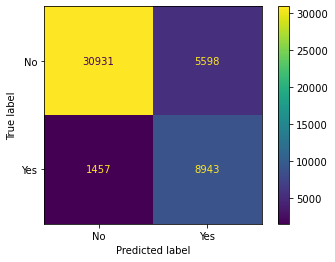

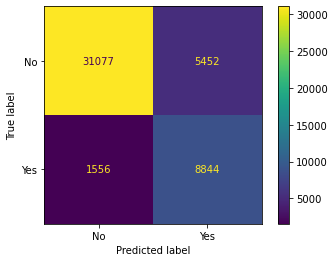

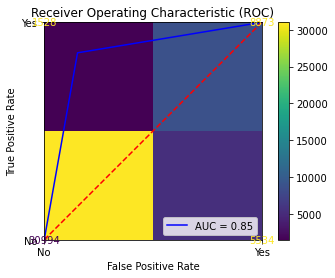

fpr [0.         0.14925128 1.        ]
tpr [0.         0.85038462 1.        ]


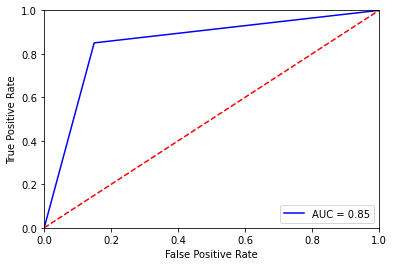

fpr [0.         0.15150022 1.        ]
tpr [0.         0.85309105 1.        ]


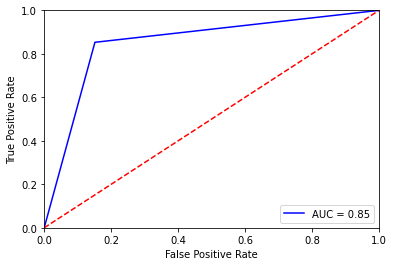

y_test ['No' 'No' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 0 1 ... 0 0 0]
y_hat ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.14807395 1.        ]
tr [0.         0.85296966 1.        ]
Iteration saga balanced 1.0 l2 0 -----> Done
y_test ['Yes' 'No' 'No' ... 'No' 'No' 'Yes']
y_test_01 [1 0 0 ... 0 0 1]
y_hat ['Yes' 'No' 'Yes' ... 'No' 'No' 'Yes']
fpr [0.         0.14806877 1.        ]
tr [0.        0.8566383 1.       ]
Iteration saga balanced 1.0 l2 1 -----> Done
y_test ['No' 'Yes' 'No' ... 'No' 'No' 'No']
y_test_01 [0 1 0 ... 0 0 0]
y_hat ['No' 'Yes' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15490009 1.        ]
tr [0.         0.85361125 1.        ]
Iteration saga balanced 1.0 l2 2 -----> Done
fpr [0.         0.14807395 1.        ]
tpr [0.         0.85296966 1.        ]


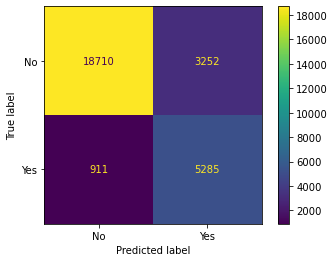

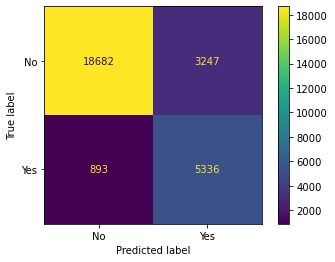

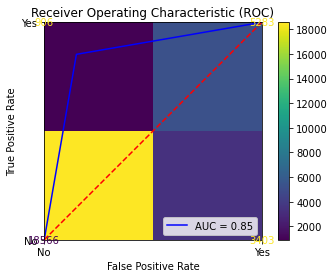

fpr [0.         0.14806877 1.        ]
tpr [0.        0.8566383 1.       ]


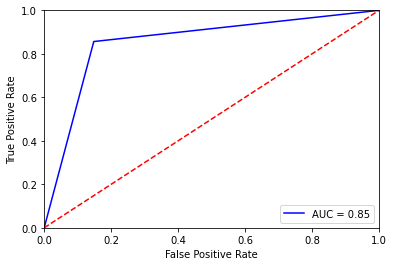

fpr [0.         0.15490009 1.        ]
tpr [0.         0.85361125 1.        ]


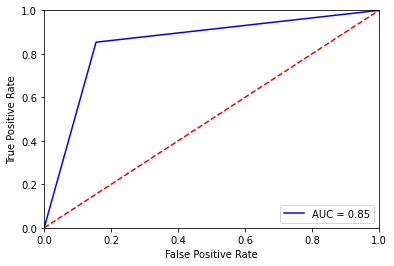

y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.        0.1532481 1.       ]
tr [0.   0.86 1.  ]
Iteration saga balanced 1.0 l2 0 -----> Done
y_test ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 1 1 ... 0 0 0]
y_hat ['No' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.14925128 1.        ]
tr [0.         0.85038462 1.        ]
Iteration saga balanced 1.0 l2 1 -----> Done
y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15147284 1.        ]
tr [0.         0.85309105 1.        ]
Iteration saga balanced 1.0 l2 2 -----> Done
fpr [0.        0.1532481 1.       ]
tpr [0.   0.86 1.  ]


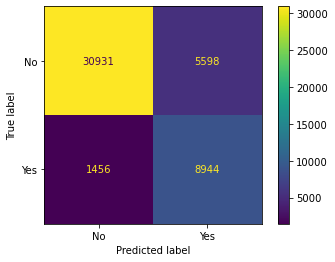

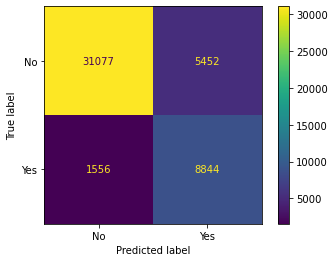

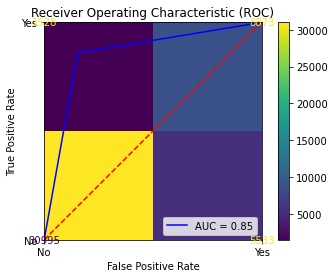

fpr [0.         0.14925128 1.        ]
tpr [0.         0.85038462 1.        ]


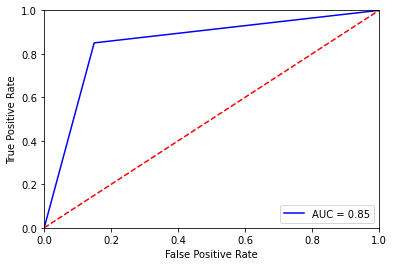

fpr [0.         0.15147284 1.        ]
tpr [0.         0.85309105 1.        ]


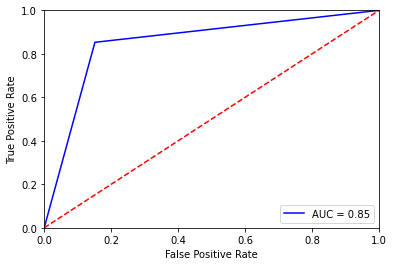

y_test ['No' 'No' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 0 1 ... 0 0 0]
y_hat ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.05637009 1.        ]
tr [0.         0.63928341 1.        ]
Iteration newton-cg None 1.0 l2 0 -----> Done
y_test ['Yes' 'No' 'No' ... 'No' 'No' 'Yes']
y_test_01 [1 0 0 ... 0 0 1]
y_hat ['Yes' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.05704774 1.        ]
tr [0.         0.64488682 1.        ]
Iteration newton-cg None 1.0 l2 1 -----> Done
y_test ['No' 'Yes' 'No' ... 'No' 'No' 'No']
y_test_01 [0 1 0 ... 0 0 0]
y_hat ['No' 'Yes' 'No' ... 'No' 'No' 'No']
fpr [0.        0.0587191 1.       ]
tr [0.         0.64388431 1.        ]
Iteration newton-cg None 1.0 l2 2 -----> Done
fpr [0.         0.05637009 1.        ]
tpr [0.         0.63928341 1.        ]


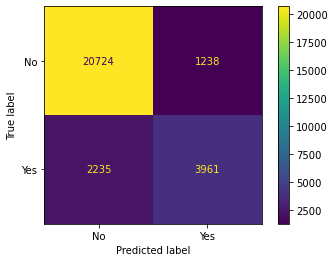

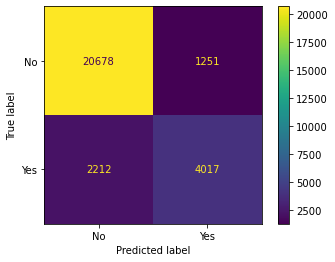

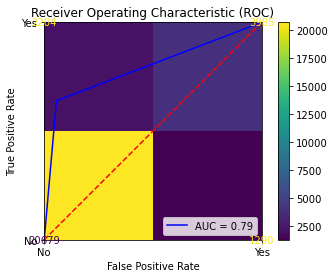

fpr [0.         0.05704774 1.        ]
tpr [0.         0.64488682 1.        ]


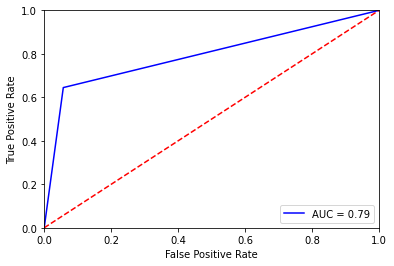

fpr [0.        0.0587191 1.       ]
tpr [0.         0.64388431 1.        ]


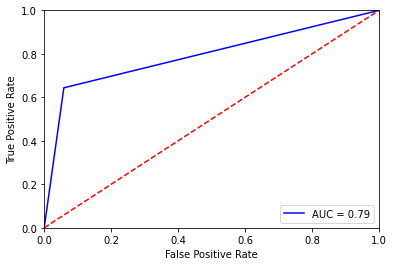

y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.05907635 1.        ]
tr [0.         0.64278846 1.        ]
Iteration newton-cg None 1.0 l2 0 -----> Done
y_test ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 1 1 ... 0 0 0]
y_hat ['No' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.        0.0575707 1.       ]
tr [0.     0.6375 1.    ]
Iteration newton-cg None 1.0 l2 1 -----> Done
y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.05896846 1.        ]
tr [0.         0.64263052 1.        ]
Iteration newton-cg None 1.0 l2 2 -----> Done
fpr [0.         0.05907635 1.        ]
tpr [0.         0.64278846 1.        ]


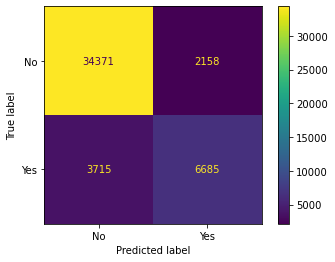

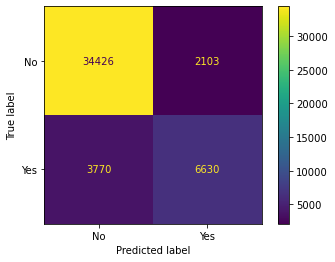

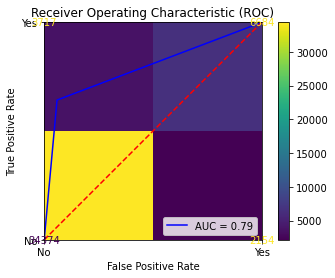

fpr [0.        0.0575707 1.       ]
tpr [0.     0.6375 1.    ]


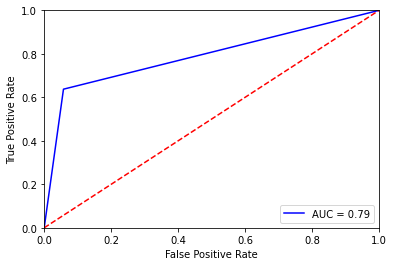

fpr [0.         0.05896846 1.        ]
tpr [0.         0.64263052 1.        ]


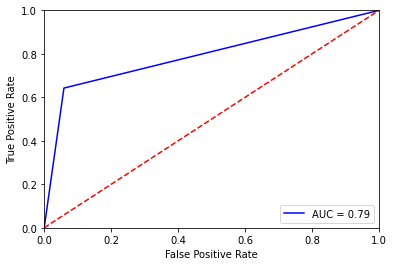

y_test ['No' 'No' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 0 1 ... 0 0 0]
y_hat ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.05637009 1.        ]
tr [0.        0.6394448 1.       ]
Iteration lbfgs None 1.0 l2 0 -----> Done
y_test ['Yes' 'No' 'No' ... 'No' 'No' 'Yes']
y_test_01 [1 0 0 ... 0 0 1]
y_hat ['Yes' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.05704774 1.        ]
tr [0.         0.64488682 1.        ]
Iteration lbfgs None 1.0 l2 1 -----> Done
y_test ['No' 'Yes' 'No' ... 'No' 'No' 'No']
y_test_01 [0 1 0 ... 0 0 0]
y_hat ['No' 'Yes' 'No' ... 'No' 'No' 'No']
fpr [0.        0.0587191 1.       ]
tr [0.         0.64404589 1.        ]
Iteration lbfgs None 1.0 l2 2 -----> Done
fpr [0.         0.05637009 1.        ]
tpr [0.        0.6394448 1.       ]


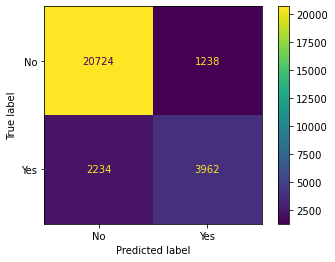

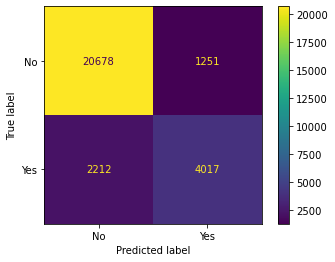

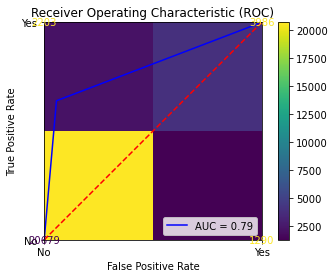

fpr [0.         0.05704774 1.        ]
tpr [0.         0.64488682 1.        ]


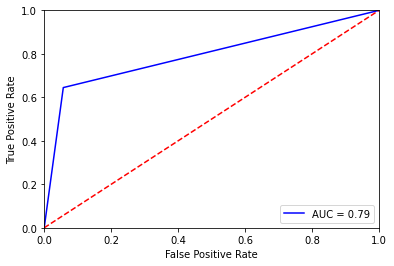

fpr [0.        0.0587191 1.       ]
tpr [0.         0.64404589 1.        ]


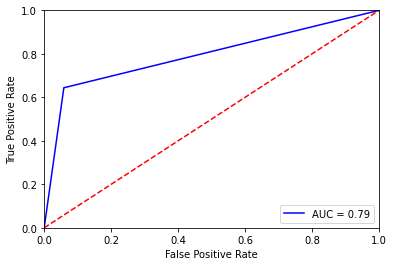

y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.05907635 1.        ]
tr [0.         0.64278846 1.        ]
Iteration lbfgs None 1.0 l2 0 -----> Done
y_test ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 1 1 ... 0 0 0]
y_hat ['No' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.        0.0575707 1.       ]
tr [0.     0.6375 1.    ]
Iteration lbfgs None 1.0 l2 1 -----> Done
y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.05896846 1.        ]
tr [0.         0.64263052 1.        ]
Iteration lbfgs None 1.0 l2 2 -----> Done
fpr [0.         0.05907635 1.        ]
tpr [0.         0.64278846 1.        ]


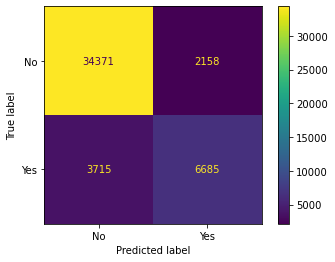

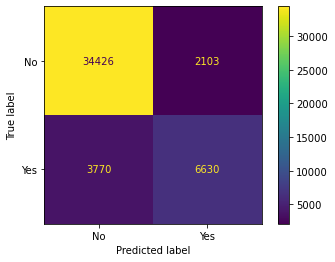

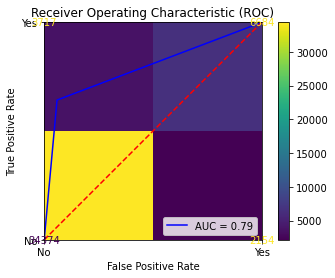

fpr [0.        0.0575707 1.       ]
tpr [0.     0.6375 1.    ]


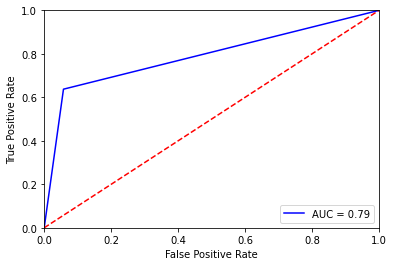

fpr [0.         0.05896846 1.        ]
tpr [0.         0.64263052 1.        ]


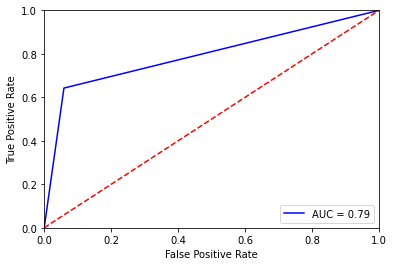

y_test ['No' 'No' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 0 1 ... 0 0 0]
y_hat ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.05637009 1.        ]
tr [0.        0.6394448 1.       ]
Iteration liblinear None 1.0 l2 0 -----> Done
y_test ['Yes' 'No' 'No' ... 'No' 'No' 'Yes']
y_test_01 [1 0 0 ... 0 0 1]
y_hat ['Yes' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.05704774 1.        ]
tr [0.         0.64488682 1.        ]
Iteration liblinear None 1.0 l2 1 -----> Done
y_test ['No' 'Yes' 'No' ... 'No' 'No' 'No']
y_test_01 [0 1 0 ... 0 0 0]
y_hat ['No' 'Yes' 'No' ... 'No' 'No' 'No']
fpr [0.        0.0587191 1.       ]
tr [0.         0.64388431 1.        ]
Iteration liblinear None 1.0 l2 2 -----> Done
fpr [0.         0.05637009 1.        ]
tpr [0.        0.6394448 1.       ]


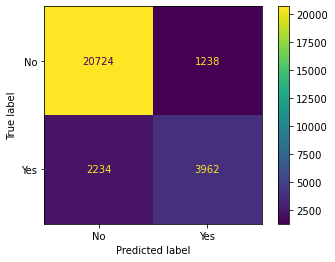

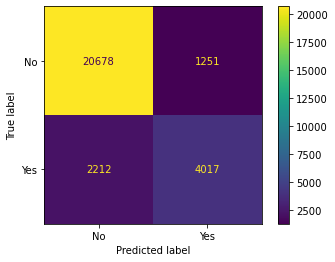

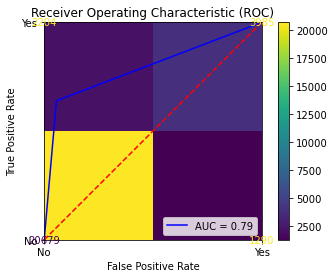

fpr [0.         0.05704774 1.        ]
tpr [0.         0.64488682 1.        ]


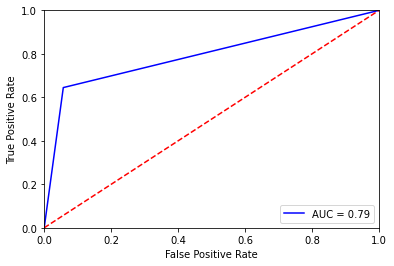

fpr [0.        0.0587191 1.       ]
tpr [0.         0.64388431 1.        ]


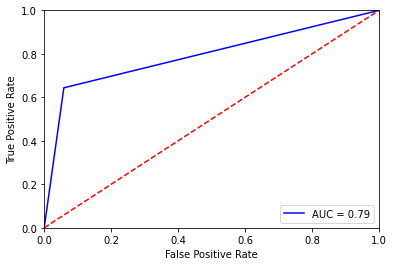

y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.05910373 1.        ]
tr [0.         0.64278846 1.        ]
Iteration liblinear None 1.0 l2 0 -----> Done
y_test ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 1 1 ... 0 0 0]
y_hat ['No' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.        0.0575707 1.       ]
tr [0.         0.63759615 1.        ]
Iteration liblinear None 1.0 l2 1 -----> Done
y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.05896846 1.        ]
tr [0.         0.64263052 1.        ]
Iteration liblinear None 1.0 l2 2 -----> Done
fpr [0.         0.05910373 1.        ]
tpr [0.         0.64278846 1.        ]


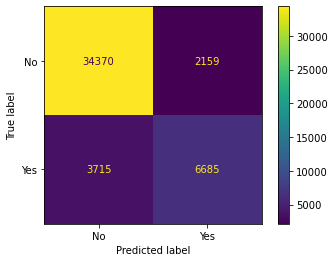

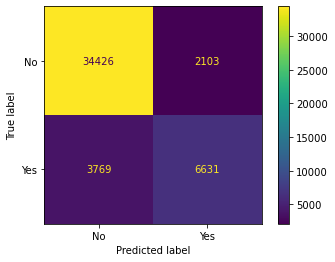

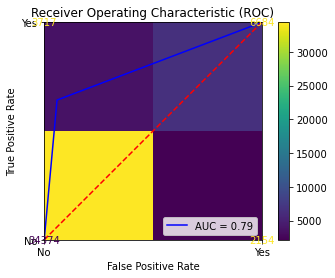

fpr [0.        0.0575707 1.       ]
tpr [0.         0.63759615 1.        ]


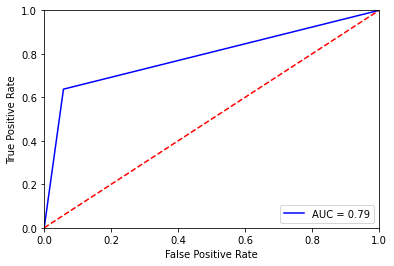

fpr [0.         0.05896846 1.        ]
tpr [0.         0.64263052 1.        ]


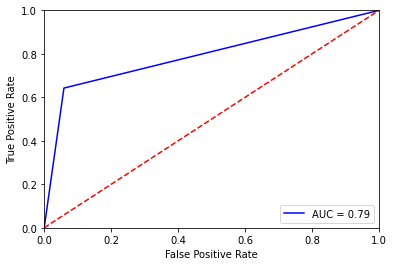

y_test ['No' 'No' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 0 1 ... 0 0 0]
y_hat ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.05637009 1.        ]
tr [0.         0.63928341 1.        ]
Iteration sag None 1.0 l2 0 -----> Done
y_test ['Yes' 'No' 'No' ... 'No' 'No' 'Yes']
y_test_01 [1 0 0 ... 0 0 1]
y_hat ['Yes' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.05704774 1.        ]
tr [0.         0.64488682 1.        ]
Iteration sag None 1.0 l2 1 -----> Done
y_test ['No' 'Yes' 'No' ... 'No' 'No' 'No']
y_test_01 [0 1 0 ... 0 0 0]
y_hat ['No' 'Yes' 'No' ... 'No' 'No' 'No']
fpr [0.        0.0587191 1.       ]
tr [0.         0.64404589 1.        ]
Iteration sag None 1.0 l2 2 -----> Done
fpr [0.         0.05637009 1.        ]
tpr [0.         0.63928341 1.        ]


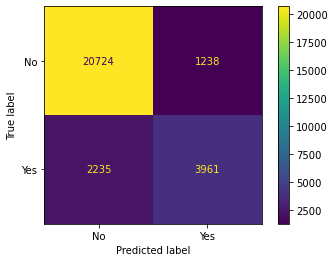

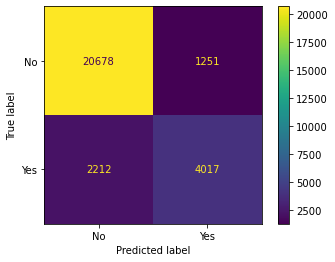

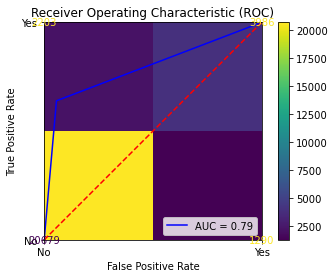

fpr [0.         0.05704774 1.        ]
tpr [0.         0.64488682 1.        ]


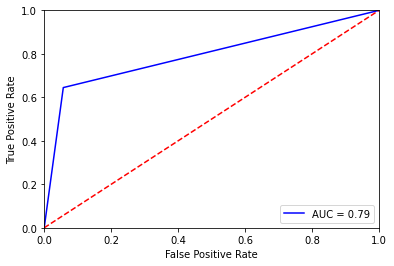

fpr [0.        0.0587191 1.       ]
tpr [0.         0.64404589 1.        ]


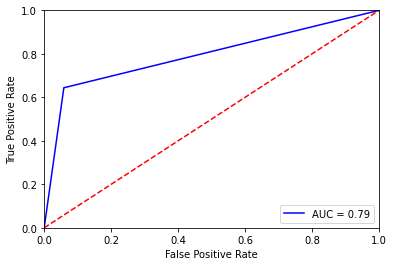

y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.05907635 1.        ]
tr [0.         0.64278846 1.        ]
Iteration sag None 1.0 l2 0 -----> Done
y_test ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 1 1 ... 0 0 0]
y_hat ['No' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.        0.0575707 1.       ]
tr [0.     0.6375 1.    ]
Iteration sag None 1.0 l2 1 -----> Done
y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.05896846 1.        ]
tr [0.         0.64263052 1.        ]
Iteration sag None 1.0 l2 2 -----> Done
fpr [0.         0.05907635 1.        ]
tpr [0.         0.64278846 1.        ]


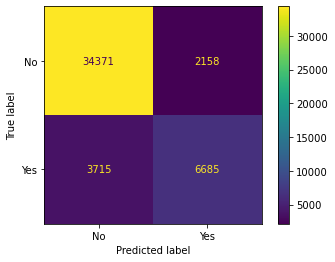

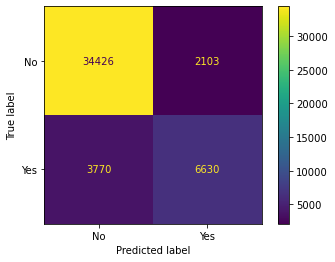

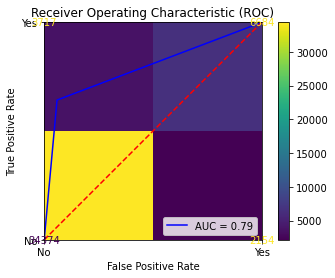

fpr [0.        0.0575707 1.       ]
tpr [0.     0.6375 1.    ]


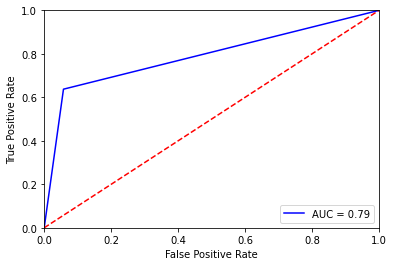

fpr [0.         0.05896846 1.        ]
tpr [0.         0.64263052 1.        ]


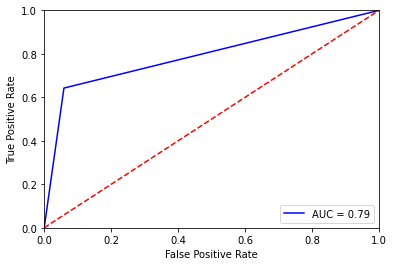

y_test ['No' 'No' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 0 1 ... 0 0 0]
y_hat ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.05637009 1.        ]
tr [0.        0.6394448 1.       ]
Iteration saga None 1.0 l2 0 -----> Done
y_test ['Yes' 'No' 'No' ... 'No' 'No' 'Yes']
y_test_01 [1 0 0 ... 0 0 1]
y_hat ['Yes' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.05704774 1.        ]
tr [0.         0.64488682 1.        ]
Iteration saga None 1.0 l2 1 -----> Done
y_test ['No' 'Yes' 'No' ... 'No' 'No' 'No']
y_test_01 [0 1 0 ... 0 0 0]
y_hat ['No' 'Yes' 'No' ... 'No' 'No' 'No']
fpr [0.        0.0587191 1.       ]
tr [0.         0.64388431 1.        ]
Iteration saga None 1.0 l2 2 -----> Done
fpr [0.         0.05637009 1.        ]
tpr [0.        0.6394448 1.       ]


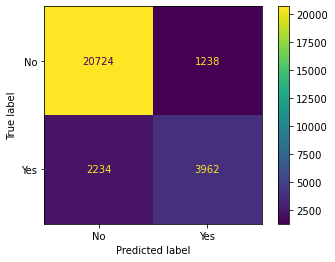

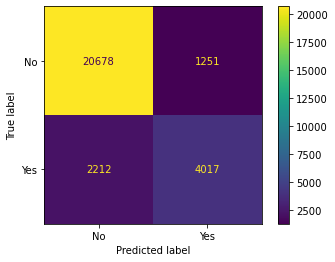

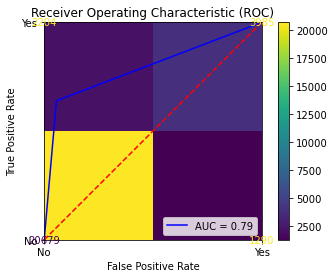

fpr [0.         0.05704774 1.        ]
tpr [0.         0.64488682 1.        ]


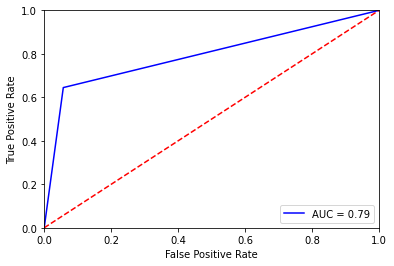

fpr [0.        0.0587191 1.       ]
tpr [0.         0.64388431 1.        ]


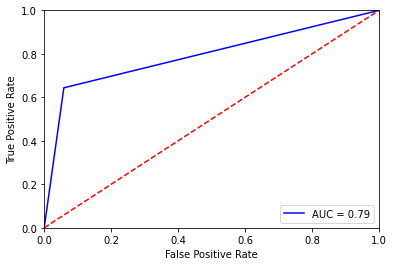

y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.05907635 1.        ]
tr [0.         0.64278846 1.        ]
Iteration saga None 1.0 l2 0 -----> Done
y_test ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 1 1 ... 0 0 0]
y_hat ['No' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.        0.0575707 1.       ]
tr [0.     0.6375 1.    ]
Iteration saga None 1.0 l2 1 -----> Done
y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.05896846 1.        ]
tr [0.         0.64263052 1.        ]
Iteration saga None 1.0 l2 2 -----> Done
fpr [0.         0.05907635 1.        ]
tpr [0.         0.64278846 1.        ]


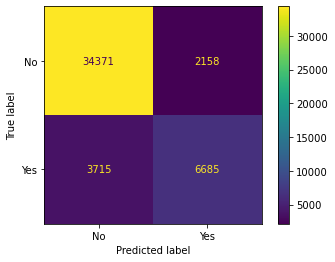

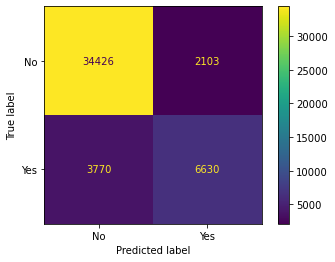

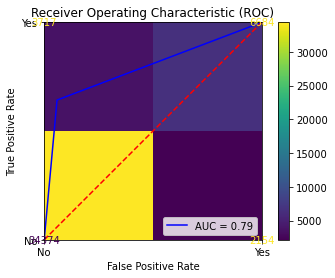

fpr [0.        0.0575707 1.       ]
tpr [0.     0.6375 1.    ]


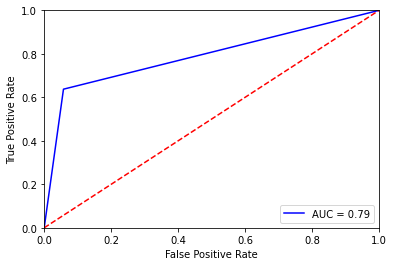

fpr [0.         0.05896846 1.        ]
tpr [0.         0.64263052 1.        ]


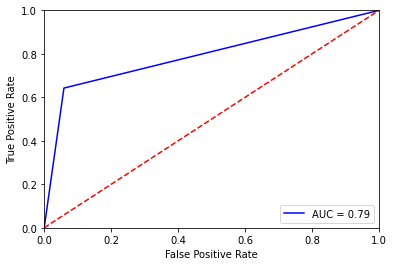

Error: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
Error in running Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.
Error in running 'NoneType' object has no attribute 'iterrows'
Error: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.
Error in running Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.
Error in running 'NoneType' object has no attribute 'iterrows'
Error: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Error in running Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Error in running 'NoneType' object has no attribute 'iterrows'
Error: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Error in running Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.
Error in running 'NoneType' object has no attribute 'iterrows'
Error: l1_ratio must be between 0 and 1; got (

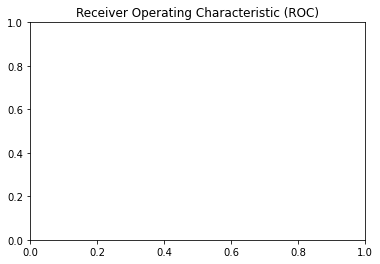

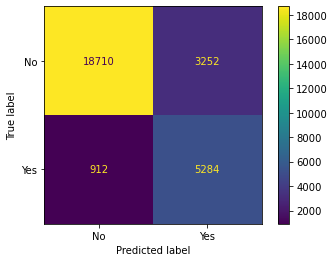

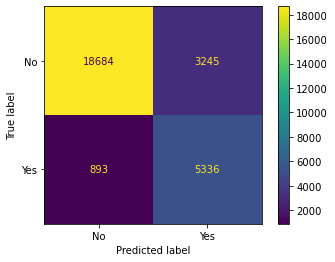

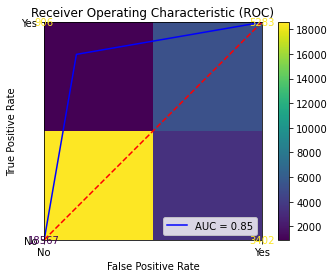

fpr [0.         0.14797756 1.        ]
tpr [0.        0.8566383 1.       ]


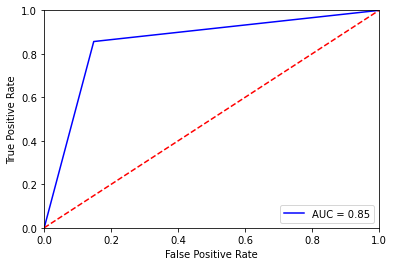

fpr [0.         0.15485457 1.        ]
tpr [0.         0.85361125 1.        ]


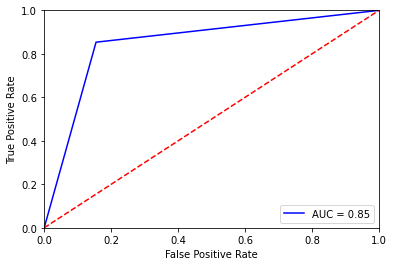

y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15330286 1.        ]
tr [0.         0.85990385 1.        ]
Iteration newton-cg balanced 1.0 none 0 -----> Done
y_test ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 1 1 ... 0 0 0]
y_hat ['No' 'No' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.14927866 1.        ]
tr [0.         0.85038462 1.        ]
Iteration newton-cg balanced 1.0 none 1 -----> Done
y_test ['No' 'No' 'No' ... 'No' 'No' 'No']
y_test_01 [0 0 0 ... 0 0 0]
y_hat ['No' 'No' 'No' ... 'No' 'No' 'No']
fpr [0.         0.15150022 1.        ]
tr [0.        0.8529949 1.       ]
Iteration newton-cg balanced 1.0 none 2 -----> Done
fpr [0.         0.15330286 1.        ]
tpr [0.         0.85990385 1.        ]


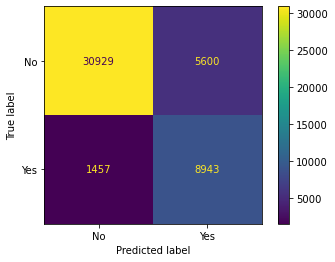

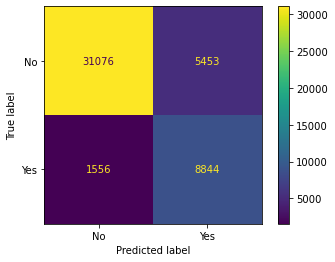

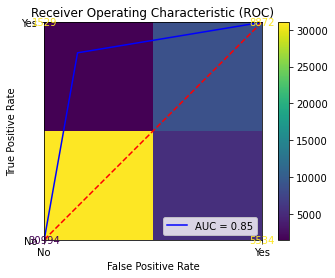

fpr [0.         0.14927866 1.        ]
tpr [0.         0.85038462 1.        ]


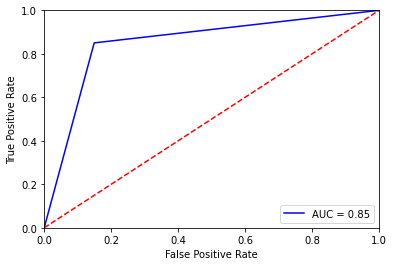

fpr [0.         0.15150022 1.        ]
tpr [0.        0.8529949 1.       ]


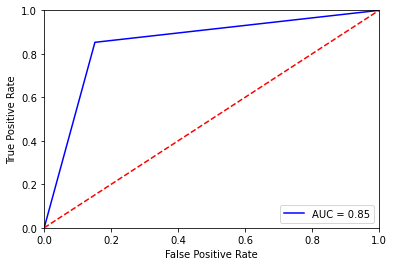

y_test ['No' 'No' 'Yes' ... 'No' 'No' 'No']
y_test_01 [0 0 1 ... 0 0 0]
y_hat ['No' 'Yes' 'Yes' ... 'No' 'No' 'No']
fpr [0.         0.14811948 1.        ]
tr [0.         0.85280826 1.        ]
Iteration lbfgs balanced 1.0 none 0 -----> Done


In [ ]:
penalty=['l1','l2', 'elasticnet', 'none']
class_weight = ['balanced', None]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
model_type = ['shuffle', 'stratified']

#penalty=['l2']
#class_weight = [None]
#solver = ['liblinear']
#model_type = ['shuffle', "stratified"]


lg_types = []
C=1.0

for pen in penalty:
    for cw in class_weight:
        for solv in solver:
            for split in model_type:
                lg_types.append([solv,cw,C,pen])
                try:
                    df_ret = create_models(model_type=split,df=df_model,iterations=3,class_weight=cw, penalty=pen, C=C, solver=solv, l1_ratio=None)
                    df_model["RainTomorrow"] = df_impute["RainTomorrow"].values
                    plt.title('Receiver Operating Characteristic (ROC)')
                    for index, row in df_ret.iterrows():
                        fpr = row["fpr"]
                        tpr = row["tpr"]
                        print("fpr", fpr)
                        print("tpr", tpr)
                        roc_auc = metrics.auc(fpr, tpr)
                        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
                        plt.legend(loc = 'lower right')
                        plt.plot([0, 1], [0, 1],'r--')
                        plt.xlim([0, 1])
                        plt.ylim([0, 1])
                        plt.ylabel('True Positive Rate')
                        plt.xlabel('False Positive Rate')
                        plt.show()
                except Exception as e:
                    print("Error in running", str(e))
                    continue
                            

df_ret_svm = create_models(model_type="svm", df=df_model, iterations=1,class_weight=None, penalty=None, C=0, solver=None, l1_ratio=None)
for index, row in df_ret_svm.iterrows():
    fpr = row["fpr"]
    tpr = row["tpr"]
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

lg_types_df = pd.DataFrame(lg_types, columns=["Solver", "ClassWeight", "C", "Penalty"])


In [ ]:
# now let's make a pandas Series with the names and values, and plot them

weights = pd.Series(lr_clf.coef_[0],index=df_model.columns)
weights.plot(kind='bar', figsize=(14,6))



In [ ]:
disp = mt.ConfusionMatrixDisplay(confusion_matrix=conf[1])
disp.plot()

In [ ]:
print(df_ret)

In [ ]:
df_model

## Alternative/Shorter version of logistic regression

In [ ]:
# this does the exact same thing as the above block of code, but with shorter syntax

for iter_num,(train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit([train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict([test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

In [ ]:
#Logistic Regression Function
#Run with various parameters
from sklearn.model_selection import cross_val_score

def logistic_regression_short(df, iterations,class_weight, penalty, solver, C, l1_ratio):
    lr_clf = LogisticRegression(penalty=penalty, C=C, class_weight=class_weight, solver=solver) 

  
    if "RainTomorrow" in df:
        y = df["RainTomorrow"].values # get the labels we want
        del df["RainTomorrow"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    rows = []
    iter_num = 0
    
    try:
        # train the reusable logisitc regression model on the training data
        accuracies = cross_val_score(lr_clf, X, y=y, cv=iterations) 
        for index, acc in enumerate(accuracies):
            rows.append([solver,class_weight,C,penalty,index, acc, None])
    except Exception as e:
        print("Error in running", solver,class_weight,C,penalty,iter_num, str(e))
        
        
    df_ret = pd.DataFrame(rows, columns=["Solver", "ClassWeight", "C", "Penalty","Iteration","Accuracy","ConfusionMatrix"])
    return df_ret

In [ ]:
# and here is an even shorter way of getting the accuracies for each training and test set

accuracies = logistic_regression_short() # this also can help with parallelism
print(accuracies)

In [ ]:
# Looking at feature importance 

import shap # SHAP for Explaining Models
shap.initjs()
# Create a tree explainer and understanding the values we have 
shap_ex = shap.LinearExplainer(lr_clf, X_test)
vals = shap_ex.shap_values(X_test)
shap.summary_plot(vals, df_model.columns, plot_type="bar")

# Reference: https://shap.readthedocs.io/en/latest/

In [ ]:
# Summarize the effect of all the features through SHAP summary plot:
explainer = shap.Explainer(lr_clf, X_train, feature_names=df_model.columns)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

# Reference: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.html

Explaining the logistic model for Rain Tomorrow prediction:

SHAP summary plots give us a birds-eye view of feature importance and what is driving it. The values of the features are their TF-IDF values.

The above SHAP summary plot is made of many dots. Each dot has three characteristics:

Vertical location shows what feature it is depicting
Color shows whether that feature was high or low for that row of the dataset.
Horizontal location shows whether the effect of that value caused a higher or lower prediction.
For example, the point in the upper left was for 'Sunshine' that caused lower chances of Rain Tomorrow, reducing the prediction by 2.

Some things the summary plot is  able to easily pick out:-

Remember that higher means more likely to be negative, so in the plots above the “red” features are actually helping raise the chance for Rain Tomorrow, while the negative features are lowering the chance for Rain Tomorrow.
The model ignored around 56 features which were of lower importance in predicting the chances of Rain Tomorrow.
Usually 'WindGustSpeed' has moderate effert on the prediction, but there are extreme cases of 'WindGustSpeed' where a high value still caused moderate level of prediction.
High values of Goal scored caused higher predictions, and low values caused low predictions

Reference: https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values

In [ ]:
# Explaining why a sample weather record # 200 is classified as Rain Tomorrow (Yes/No)?
ind = 200
shap.plots.force(shap_values[ind])
# Reference: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.html

In [ ]:
# Heatmap plot provides another global view of the model’s behavior, with a focus on predictions for Rain Tomorrow.
#shap.plots.heatmap(shap_values)

In [ ]:
groups_by_time = {
    '3pm': [f for f in df_impute if '3pm' in f],
    '9am': [f for f in df_impute if '9am' in f],
    'not_time_based': [f for f in df_impute if '9am' not in f and '3pm' not in f]
}

groups_by_type = {
    'humidity_and_rain': ['Rainfall',
                          'Evaporation',
                          'Humidity9am',
                          'Humidity3pm',
                          'RainToday'],
    'temperature': ['MinTemp',
                    'MaxTemp',
                    'Temp9am',
                    'Temp3pm'],
    'sun_and_clouds': ['Cloud9am',
                       'Cloud3pm',
                       'Sunshine'],
    'wind_and_pressure': ['WindGustDir',
                          'WindGustSpeed',
                          'WindDir9am',
                          'WindDir3pm',
                          'WindSpeed9am',
                          'WindSpeed3pm',
                          'Pressure9am',
                          'Pressure3pm'],
    'location': ['Location']
}

shap_time = grouped_shap(shap_vals, df_impute, groups_by_time)
shap_type = grouped_shap(shap_vals, df_impute, groups_by_type)



### Oversampled


In [ ]:

no = df_impute[df_impute.RainTomorrow == 0]
yes = df_impute[df_impute.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

In [ ]:
#get_dummies using oversampled dataframe

# perform one-hot encoding of the categorical data "embarked"
gust_df = pd.get_dummies(oversampled.WindGustDir,prefix='GustDir')
wind3pm_df = pd.get_dummies(oversampled.WindDir3pm,prefix='Wind3pm')
wind9am_df = pd.get_dummies(oversampled.WindDir9am,prefix='Wind9am')
oversampled = pd.concat((oversampled,gust_df, wind3pm_df, wind9am_df),axis=1) # add back into the dataframe

# replace the current Sex atribute with something slightly more intuitive and readable
oversampled['IsRainToday'] = oversampled.RainToday=='Yes' 
oversampled.IsRainToday = oversampled.IsRainToday.astype(np.int)

oversampled.info()

In [ ]:
fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

In [ ]:
len(oversampled)

In [ ]:
# Dropping categorical columns

oversampled = oversampled.drop(['WindDir3pm', 'WindDir9am', 'WindGustDir', 'RainToday'], axis = 1)

In [ ]:
#Shufflesplit using oversampled dataframe

from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if "RainTomorrow" in oversampled:
    y = oversampled["RainTomorrow"].values # get the labels we want
    del oversampled["RainTomorrow"] # get rid of the class label
    X_over = oversampled.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object_over = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state = 123)
                         
print(cv_object_over)